# TP-Percussions : accord ou pas d’accord ?

## Preparation

### Instruments and Devices
- Timbale, Glockenspiel, Vibraphone and drumsticks
- Microphone and audio interface

### Choices of knocking points
- Timbale: the center of the drumhead, the edge (~10cm to the edge) of the drumhead
- Glockenspiel: the center of the bar, the quarter point of the bar, the nodal point of the bar
- Vibraphone: the center of the bar, the quarter point of the bar, the nodal point of the bar

### Implementation
- Use drumstick to knock the instruments at the chosen points, and record the sound with the microphone and audio interface. 
- During the recording, the microphone should be placed at a fixed position and the environment should be quiet to avoid the noise. 
- Until the sound is diminished, the recording should be stopped.

## Data Analysis
For each configuration(different timbres) of instrument, we have recorded the sound for different knocking points. We use FFT and MUSIC algorithm to analyze the frequency of the sound and the knocking point.
- Choice of the period of the signal: we choose the first point with its amplitude greater than 0.5 as the start point, and the first point from start point with its amplitude less than 0.01 as the end point.
- Number of fft points keeps the same as the number of MUSIC algorithm points, which is 2048.

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
import pandas as pd
from scipy.linalg import hankel
import re

### functions

In [2]:
def my_fft(sig, N_fft, Fs):

    X_fft = X_fft = np.fft.fft(sig, n=N_fft)
    freqs = np.fft.fftfreq(N_fft, 1/Fs)

    # only use the positive frequencies
    half_n = N_fft // 2
    X_fft = X_fft[:half_n]
    freqs = freqs[:half_n]

    return X_fft, freqs

# get hankel matrix of x: X
def get_hankel(x, n):
    X = hankel(x[:n], x[n-1:])
    return X

# get correlation of X: R_xx
def get_correlation(X, l):
    # l = x.shape[0] - n + 1
    R_xx = X @ X.transpose().conj() / l
    return R_xx

# get signal space W and Wt
def get_W(R_xx, K):
    U, _, Vh = np.linalg.svd(R_xx)
    W = U[:, :K]
    Wt = Vh[:, K:]
    return W, Wt

def get_delta_f(W):
    # get W_up and W_down from W
    W_up = W[1:, :]
    W_down = W[:-1, :]

    # compute Phi
    Phi = np.linalg.pinv(W_down) @ W_up

    # get eigenvalues of Phi
    zk,_ = np.linalg.eig(Phi)

    delta_k = np.log(np.abs(zk))
    f_k = np.angle(zk) / (2 * np.pi)

    return delta_k, f_k

def ESPRIT(x, n, K, threshold=None):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, l=x.shape[0] - n + 1)
    W, Wt = get_W(R_xx, K)
    delta_k, f_k = get_delta_f(W)
    # for the case of delta > 0, use a threshold instead
    if threshold != None:
        delta_k = [min(delta, threshold) for delta in delta_k]
    return delta_k, f_k

def LeastSquares(x, delta, f):
    ln_z = delta + 2j * np.pi * f
    V = np.exp(np.outer(np.arange(x.shape[0]), ln_z))
    alpha = np.linalg.pinv(V) @ x.transpose()
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

def MUSIC(x, n, K, delta_grid, f_grid):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, l=x.shape[0] - n + 1)
    _, Wt = get_W(R_xx, K)
    v_n_z = np.vander((np.exp(delta_grid + 2j * np.pi * f_grid)).flatten(), n, increasing=True).T 
    product = np.dot(Wt.conj().transpose(), v_n_z)
    norm_square = np.linalg.norm(product, axis=0) ** 2
    P = 1 / norm_square
    P = P.reshape(delta_grid.shape)
    return P

def load_signal(config, normalize=True):
    file_list = os.listdir(config['data folder'])
    signals = pd.DataFrame(columns=['file_name', 'signal', 'Fs'])

    for idx, file in enumerate(file_list):
        x, Fs = sf.read(os.path.join(config['data folder'], file))
        x = x[:, 0]
        if normalize:
            # normalize the signal
            x = x / np.max(np.abs(x))
        signals.loc[idx] = [file, x, Fs]
    return signals

def get_freq_plot(config, signals):
    N_fig = len(signals)
    pattern = r"(F\dsharp|G\dsharp|F|G)?_?(middle|up|down|side)?_?(F\dsharp|G\dsharp|F|G)?"
    freq_components = pd.DataFrame(columns=['file_name', 'position', 'timbre', 'freq', 'amp', 'amorti_time'])

    fig, ax = plt.subplots(N_fig, 2, figsize=(10, 20))
    for idx, file_name, x, Fs in signals.itertuples():
        freq_components.loc[idx] = [file_name, None, None, None, None, None]
        # use regular expression to extract position and timbre from file name

        match = re.search(pattern, file_name)
        freq_components.loc[idx, 'position'] = match.group(2) if match.group(2) else "N/A"
        if match.group(1):
            freq_components.loc[idx, 'timbre'] = match.group(1)
        elif match.group(3):
            freq_components.loc[idx, 'timbre'] = match.group(3)
        else:
            freq_components.loc[idx, 'timbre'] = "N/A"

        # MUSIC method
        K = config['ESPRIT K']
        n = config['ESPRIT n']
        l = config['ESPRIT l']
        
        N = n + l - 1
        start = np.argmax(x > config['start point threshold'])
        sig = x[start: start + N]
        # get end point of amortissement
        end = np.argmax(x[start:] < config['end amorti threshold']) + start
        amorti_time = (end - start) / Fs
        freq_components.at[idx, 'amorti_time'] = amorti_time

        # FFT method
        X_fft, freqs = my_fft(sig, config['FFT NUM'], Fs)
        # normalize X_fft
        X_fft = X_fft / np.max(np.abs(X_fft))
        
        ax[idx, 0].plot(x, label='collected signal')
        ax[idx, 0].set_title(file_name)
        ax[idx, 1].plot(freqs, np.abs(X_fft), label='FFT')
        ax[idx, 1].set_title(file_name)

        sig_delta, sig_f = ESPRIT(sig, n, K, threshold=-1e-5)
        sig_a, sig_phi = LeastSquares(sig, sig_delta, sig_f)
        
        # sort sig_a, sig_phi, sig_delta, sig_f by sig_f
        sig_a = sig_a[np.argsort(sig_f)]
        sig_f = np.sort(sig_f)
        # only show positive frequencies for sig_f and sig_a
        sig_f = sig_f[K//2:]
        sig_a = sig_a[K//2:]
        # normalize sig_a
        sig_a = sig_a / np.max(np.abs(sig_a))

        freq_components.at[idx, 'freq'] = list(sig_f * Fs)
        freq_components.at[idx, 'amp'] = list(sig_a)

        ax[idx, 0].plot(range(start, start + N), sig, label='used signal', color='red')
        ax[idx, 1].scatter(sig_f * Fs, sig_a, label='ESPRIT', color='red')
        ax[idx, 1].vlines(sig_f * Fs, np.zeros_like(sig_f), sig_a, color='red')
        # note frequency in x-axis
        ax[idx, 1].set_xticks(sig_f * Fs)
        ax[idx, 0].legend()
        ax[idx, 1].legend()
        ax[idx, 1].set_xlim(config['xlim'])

        # print(f'-----{file_name}-----\n{sig_f * Fs}')
        # print the principal frequency, the one with the highest amplitude
        freq_principal = sig_f[np.argmax(sig_a)]
        print(f'-----{file_name}-----\n{freq_principal * Fs}')
    plt.tight_layout()
    plt.show()
    return freq_components

## Timpani

In [3]:
config = {
    'data folder': 'data/timpani',
    'start point threshold': 0.5, # threshold for start point detection
    'end amorti threshold': 0.01, # threshold for end point detection
    'FFT NUM': 2048,
    'ESPRIT K': 40,
    'ESPRIT n': 2048,
    'ESPRIT l': 2048 * 20,
    'xlim': [0, 1000]
}

-----middle_F1sharp.wav-----
157.81253603621633
-----middle_G1sharp.wav-----
127.40002846264909
-----side_F1sharp_2.wav-----
160.70617029952643
-----side_G1sharp_1.wav-----
186.07186430152498


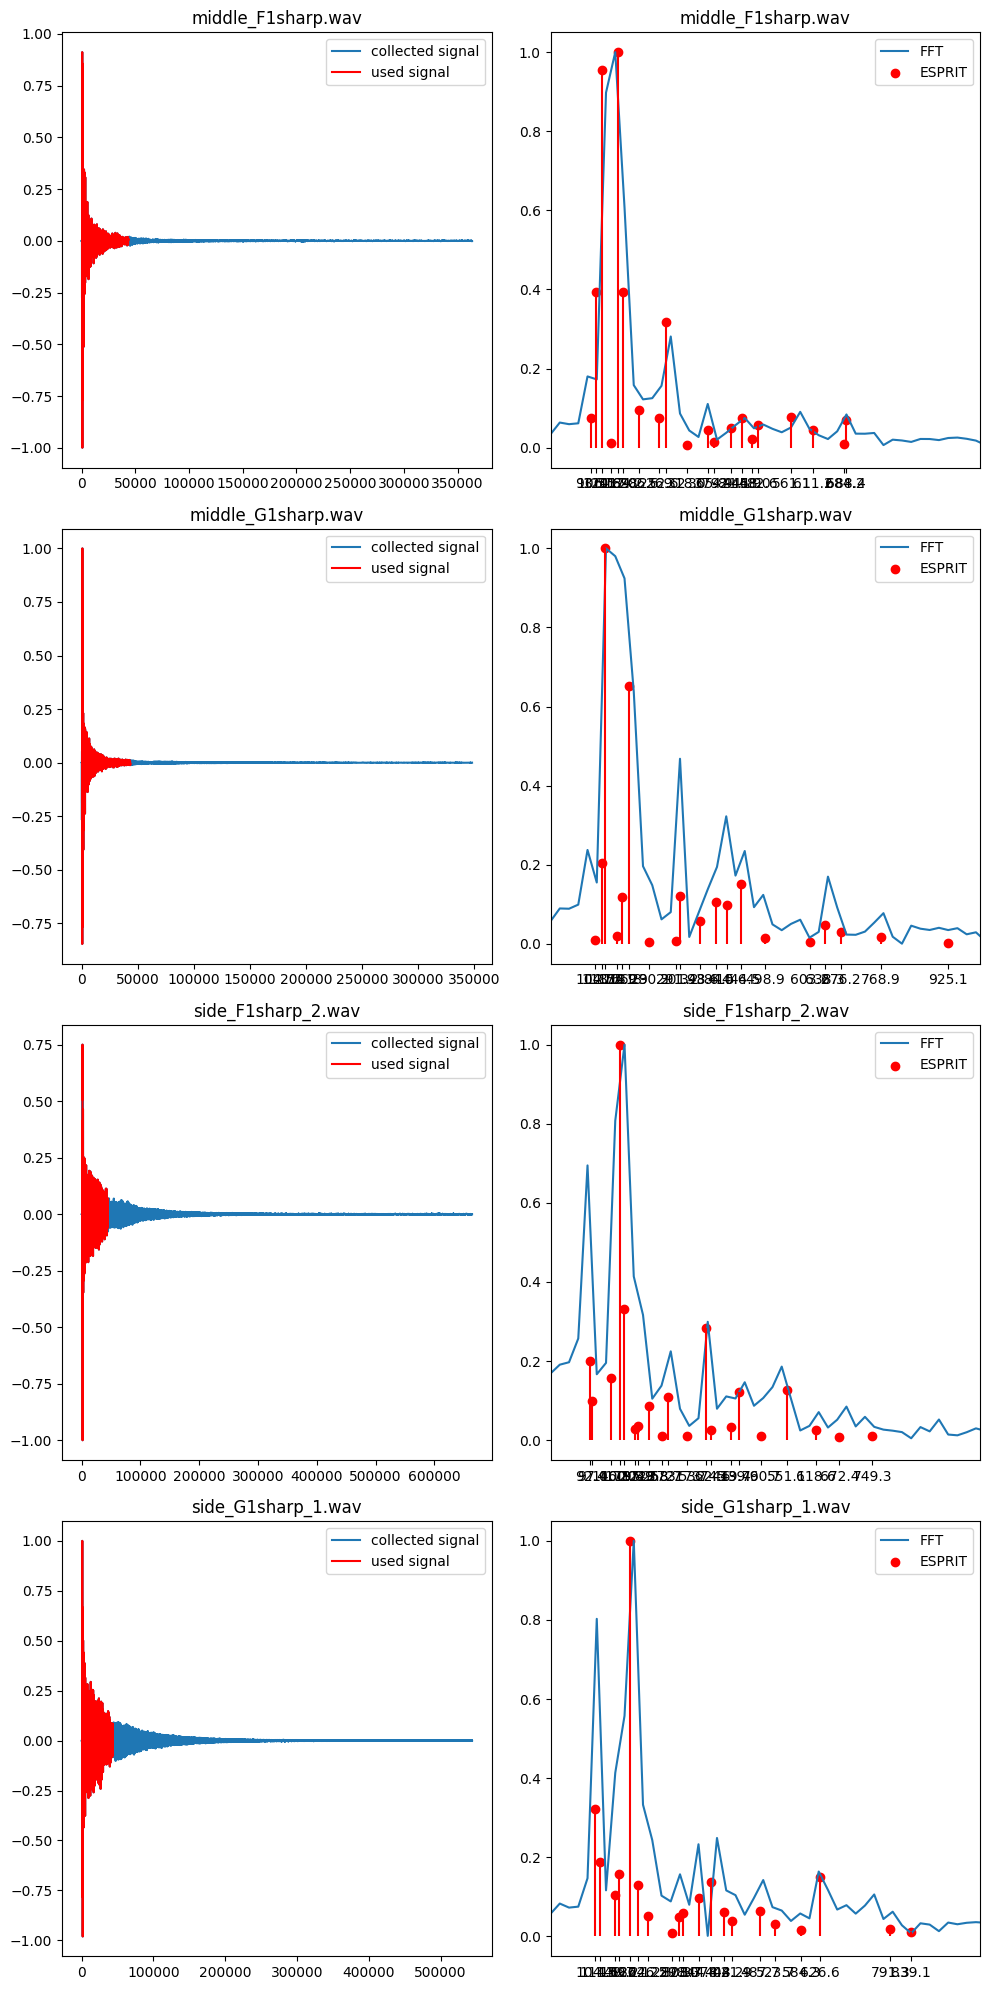

In [4]:
signals = load_signal(config)
freq_components = get_freq_plot(config, signals)

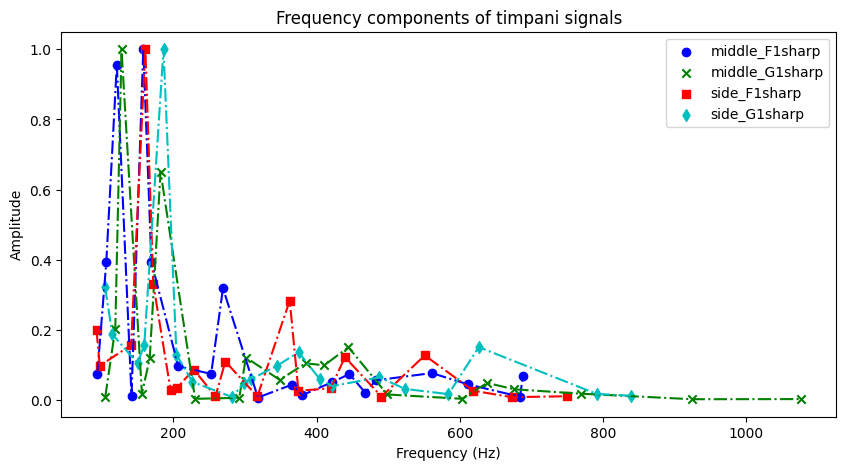

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
marker = ['o', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for idx, row in freq_components.iterrows():
    file_name = row['file_name']
    position = row['position']
    timbre = row['timbre']
    freq = row['freq']
    amp = row['amp']
    label = f'{position}_{timbre}'
    ax.scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
    ax.plot(freq, amp, linestyle='-.', color=colors[idx]) 
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency components of timpani signals')
plt.show()


## Glockenspiel

In [6]:
config = {
    'data folder': 'data/glockenspiel',
    'start point threshold': 0.5, # threshold for start point detection
    'end amorti threshold': 0.01, # threshold for end point detection
    'FFT NUM': 2048,
    'ESPRIT K': 40,
    'ESPRIT n': 2048,
    'ESPRIT l': 2048 * 20,
    'xlim': [0, 10000]
}

-----F_down.wav-----
3673.570910698183
-----F_middle.wav-----
5578.98675021808
-----F_up.wav-----
3664.728010525942
-----G_down.wav-----
7512.983749623968
-----G_middle.wav-----
4882.230378120358
-----G_up.wav-----
4265.812332374855


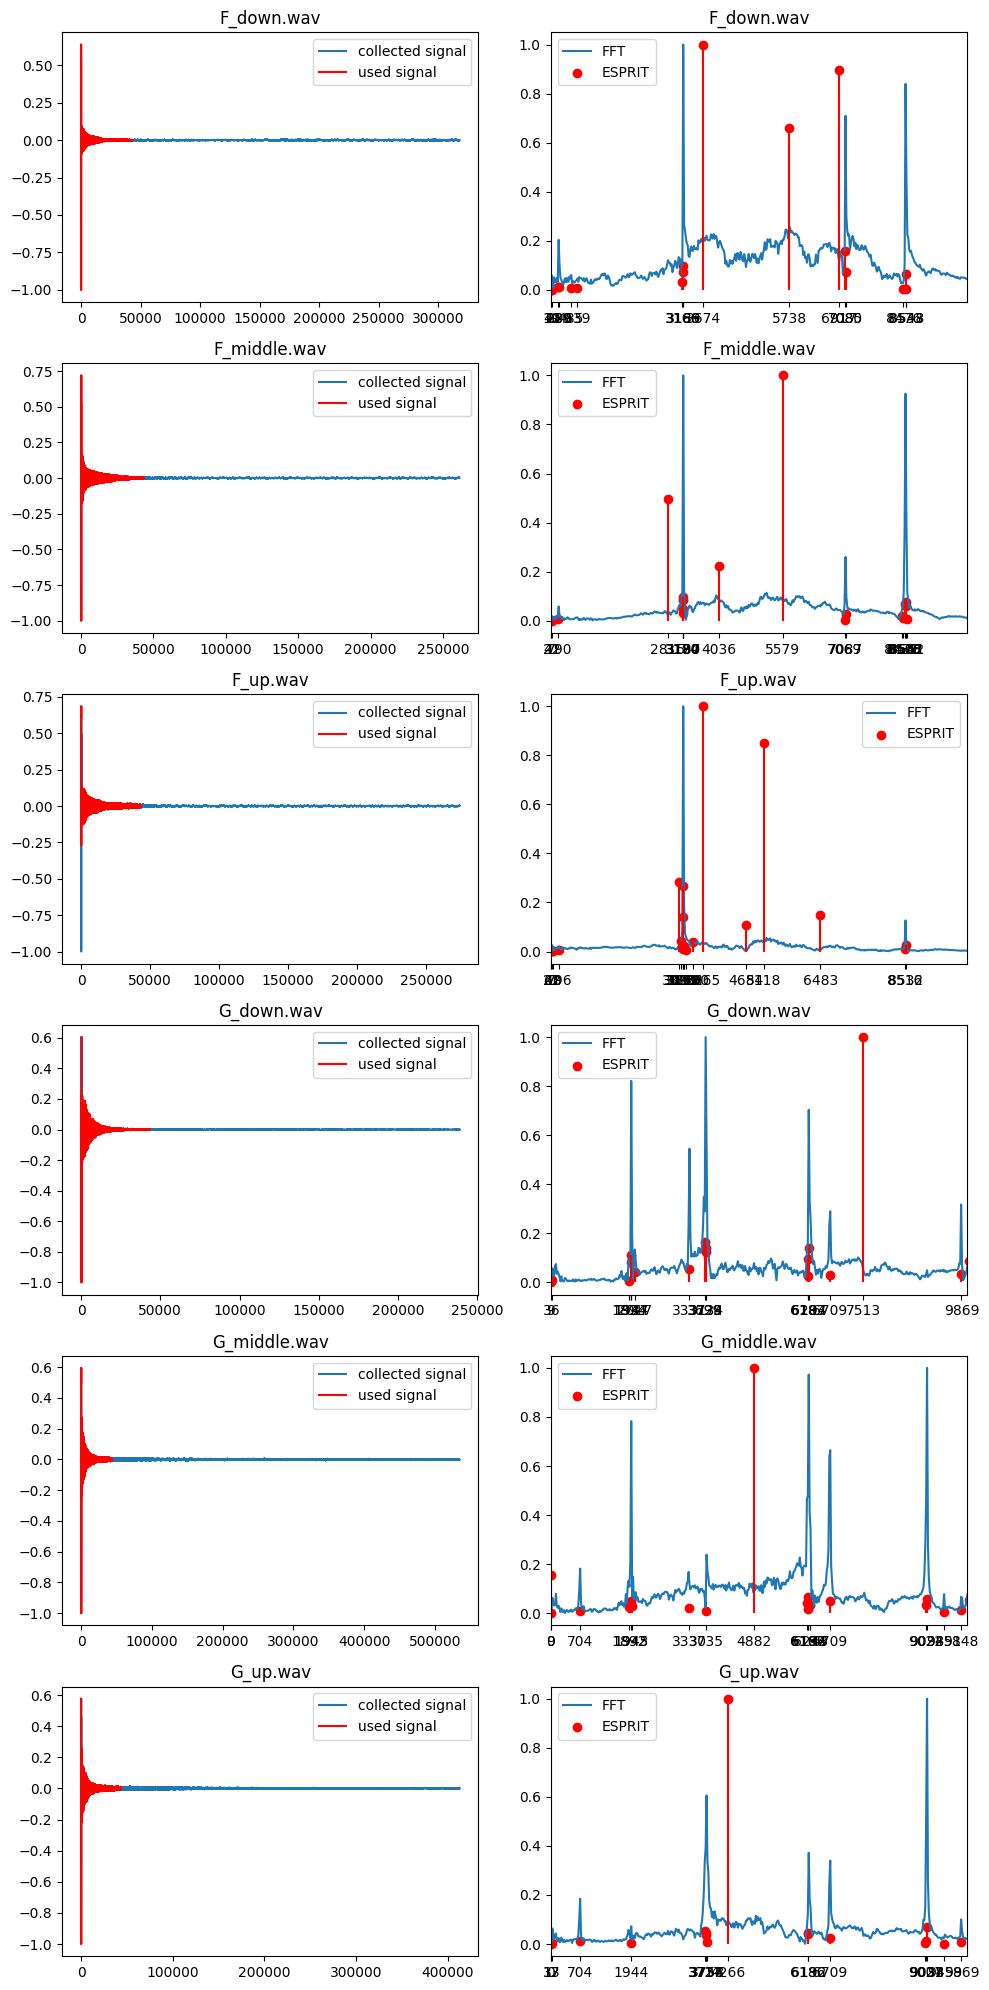

In [7]:
signals = load_signal(config)
freq_components = get_freq_plot(config, signals)

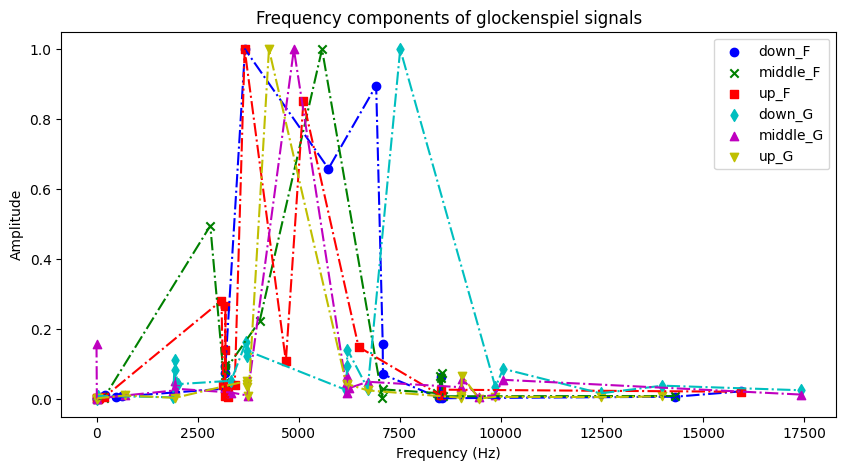

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
marker = ['o', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for idx, row in freq_components.iterrows():
    file_name = row['file_name']
    position = row['position']
    timbre = row['timbre']
    freq = row['freq']
    amp = row['amp']
    label = f'{position}_{timbre}'
    ax.scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
    ax.plot(freq, amp, linestyle='-.', color=colors[idx]) 
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency components of glockenspiel signals')
plt.show()


## Vibraphone

-----F_down.wav-----
1328.2050664221322
-----F_middle.wav-----
175.66354598698985
-----F_up.wav-----
1876.8647588200756
-----G_down.wav-----
1478.8817063473534
-----G_middle.wav-----
1563.438889761078
-----G_up.wav-----
788.3136651165355


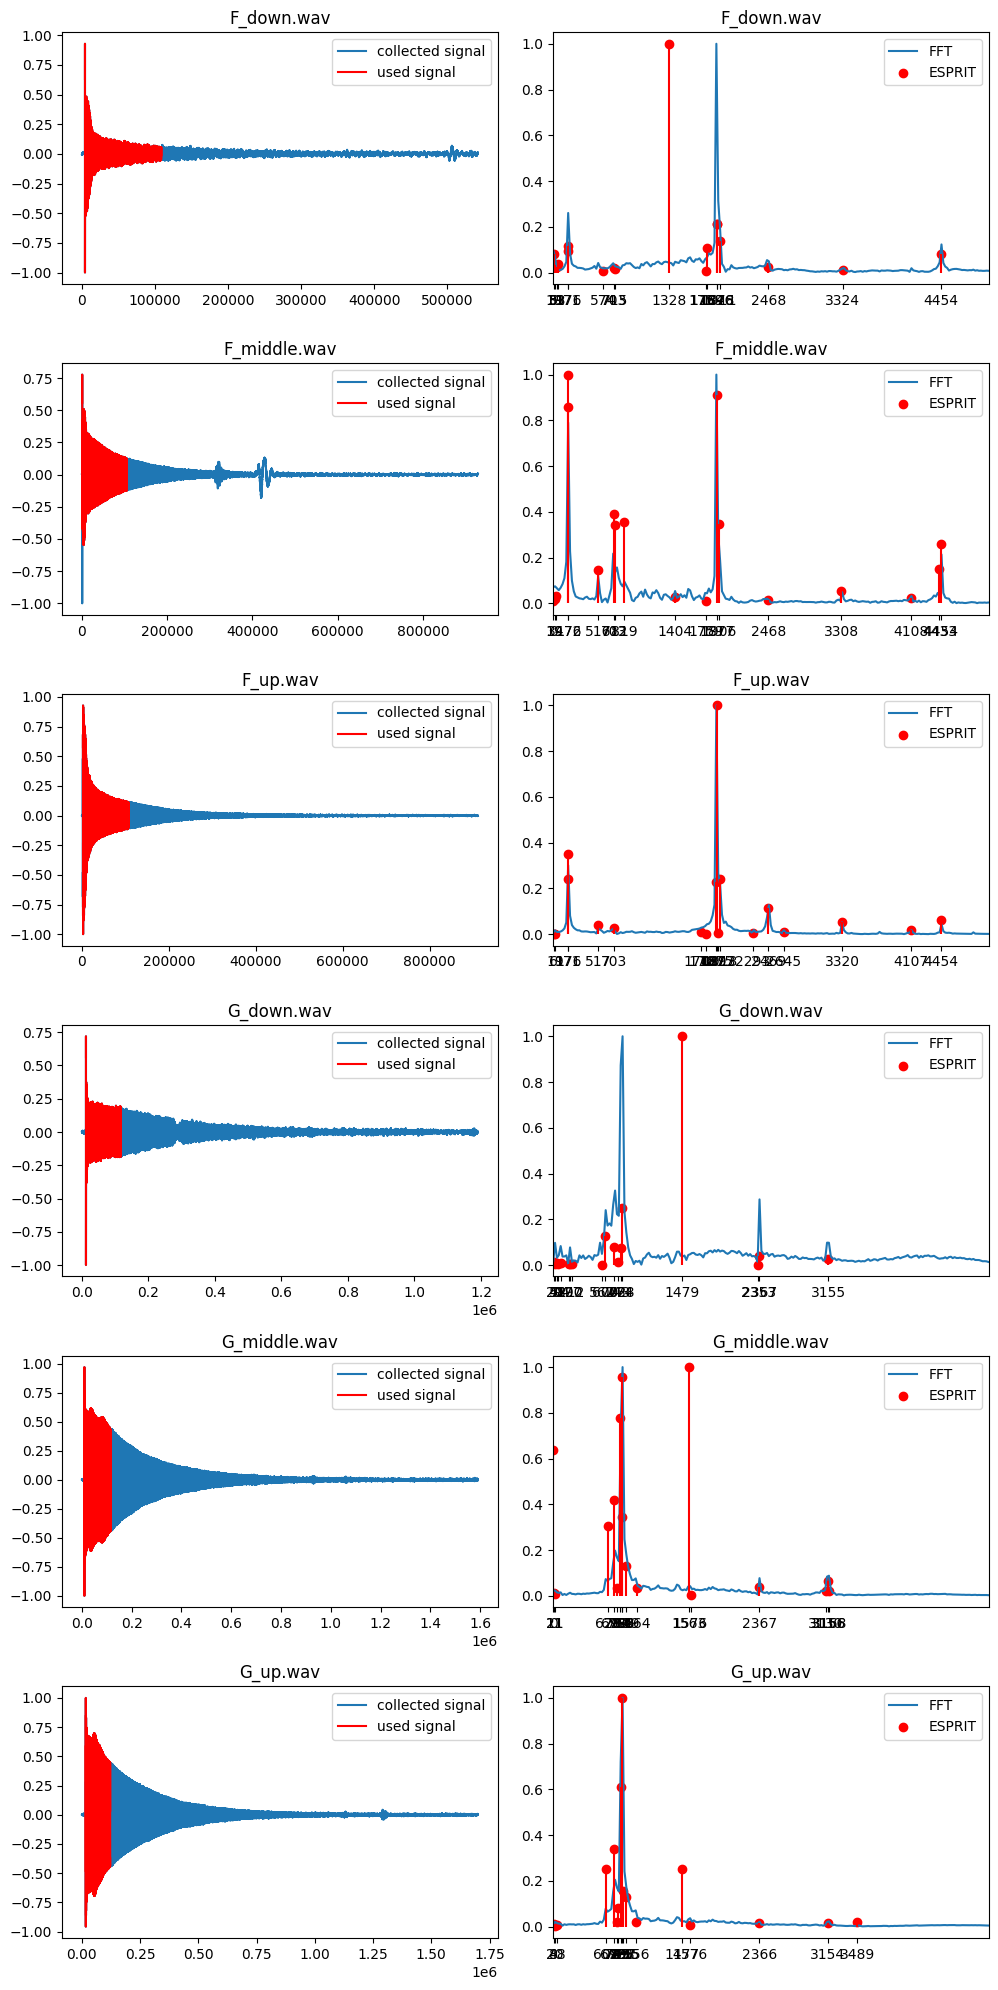

In [9]:
config = {
    'data folder': 'data/vibraphone',
    'start point threshold': 0.5, # threshold for start point detection
    'end amorti threshold': 0.01, # threshold for end point detection
    'FFT NUM': 2048,
    'ESPRIT K': 40,
    'ESPRIT n': 2048,
    'ESPRIT l': 2048 * 50,
    'xlim': [0, 5000]
}

signals = load_signal(config)
freq_components = get_freq_plot(config, signals)

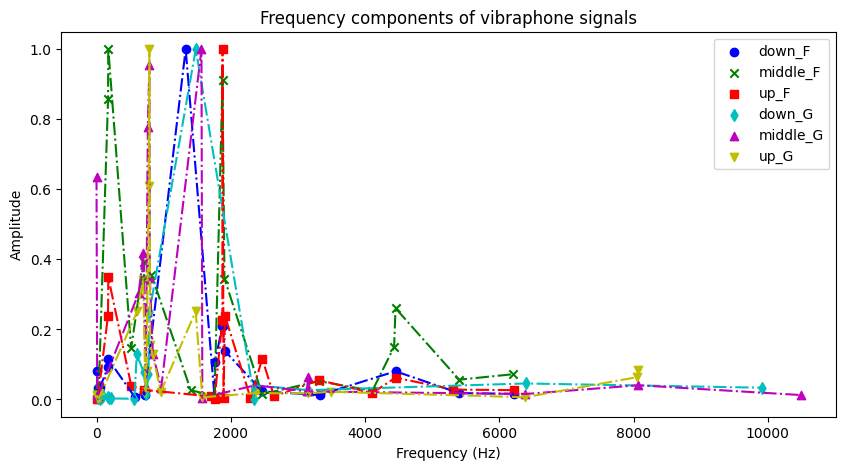

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
marker = ['o', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for idx, row in freq_components.iterrows():
    file_name = row['file_name']
    position = row['position']
    timbre = row['timbre']
    freq = row['freq']
    amp = row['amp']
    label = f'{position}_{timbre}'
    ax.scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
    ax.plot(freq, amp, linestyle='-.', color=colors[idx]) 
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency components of vibraphone signals')
plt.show()
